In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

/tmp/ipykernel_40573/351836786.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_available_device() -> str:
    """Returns the device based on the system configuration."""
    if torch.cuda.is_available():
        return torch.device('cuda').type
    if torch.backends.mps.is_available():
        return torch.device('mps').type  # https://pytorch.org/docs/stable/notes/mps.html
    return torch.device('cpu').type

device = get_available_device()
print(f"Using device: {device}")

Using device: cuda


In [3]:
DIMENSIONS = (28, 28)
CHANNELS = 1  # grayscale
INPUT_SIZE = DIMENSIONS[0] * DIMENSIONS[1]
OUTPUT_SIZE = 10

def transform_data(
        is_convolutional: bool,
        x: pd.DataFrame,
        y: pd.Series | None = None) -> tuple[torch.tensor, torch.tensor]:
    """
    Transforms the data. Returns a tuple of (x, y) where x is a tensor of the features and y is a
    tensor of the labels.

    Args:
        is_convolutional: A boolean indicating whether the model is convolutional.
        x: A dataframe of the features.
        y: A series of the labels.
    """
    x = torch.tensor(x.values, dtype=torch.float32)
    # Normalize the tensor
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    assert x.min() == 0
    assert x.max() == 1
    if is_convolutional:
        # Reshape data to have channel dimension
        # MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
        x = x.reshape(-1, CHANNELS, DIMENSIONS[0], DIMENSIONS[1])
    if y is not None:
        y = torch.tensor(y.astype(int).values, dtype=torch.long)
    return x, y


def get_data():  # noqa
    """Function is required by and called from `model_pipeline()`."""
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    x, y = transform_data(is_convolutional=False, x=x, y=y)
    # 80% train; 10% validation; 10% test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
    print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
    print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
    print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_data()

Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


In [4]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    """A Multilayer Perceptron (MLP) model in PyTorch with one hidden layer."""

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(INPUT_SIZE, 100),
            nn.ReLU(),
            nn.Linear(100, OUTPUT_SIZE),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x: Input tensor.

        Returns:
            Tensor after passing through the layers and activations.
        """
        return self.layers(x)

learning_rate = 0.01
epochs = 15
batch_size = 32

x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = MLP()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
losses = []
val_losses = []

for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        if i % 200 == 0:
            losses.append(loss.item())
            # calculate validation loss
            with torch.no_grad():
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss.item())
            print(f"Epoch {epoch}, Batch {i:04}, training loss {round(loss.item(), 3)}, validation loss {round(val_loss.item(), 3)}")  # noqa
print(f"Epoch {epoch}, Batch {i:04}, training loss {round(loss.item(), 3)}, validation loss {round(val_loss.item(), 3)}")  # noqa

Epoch 0, Batch 0000, training loss 2.273, validation loss 2.291
Epoch 0, Batch 0200, training loss 1.772, validation loss 1.824
Epoch 0, Batch 0400, training loss 1.256, validation loss 1.207
Epoch 0, Batch 0600, training loss 1.145, validation loss 0.849
Epoch 0, Batch 0800, training loss 0.712, validation loss 0.674
Epoch 0, Batch 1000, training loss 0.632, validation loss 0.575
Epoch 0, Batch 1200, training loss 0.607, validation loss 0.516
Epoch 0, Batch 1400, training loss 0.441, validation loss 0.471
Epoch 0, Batch 1600, training loss 0.243, validation loss 0.443
Epoch 1, Batch 0000, training loss 0.495, validation loss 0.425
Epoch 1, Batch 0200, training loss 0.572, validation loss 0.405
Epoch 1, Batch 0400, training loss 0.395, validation loss 0.39
Epoch 1, Batch 0600, training loss 0.358, validation loss 0.377
Epoch 1, Batch 0800, training loss 0.265, validation loss 0.367
Epoch 1, Batch 1000, training loss 0.286, validation loss 0.356
Epoch 1, Batch 1200, training loss 0.27, 

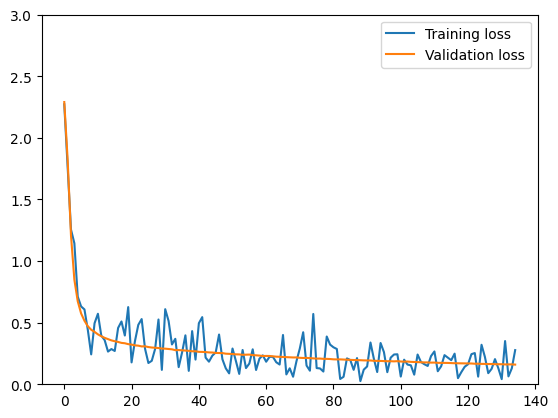

In [5]:
# plot losses over time
plt.plot(losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.ylim(0, 3)
plt.legend()

In [6]:
x_test = x_test.to(device)
y_test = y_test.to(device)

# test the model
with torch.no_grad():
    outputs = model(x_test)
    loss = criterion(outputs, y_test)
    print(f"Test loss: {loss}")
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f"Test accuracy: {accuracy:.3f}")

Test loss: 0.1868087500333786
Test accuracy: 0.947


Text(0.5, 1.0, 'Count of Misclassified Samples by Class')

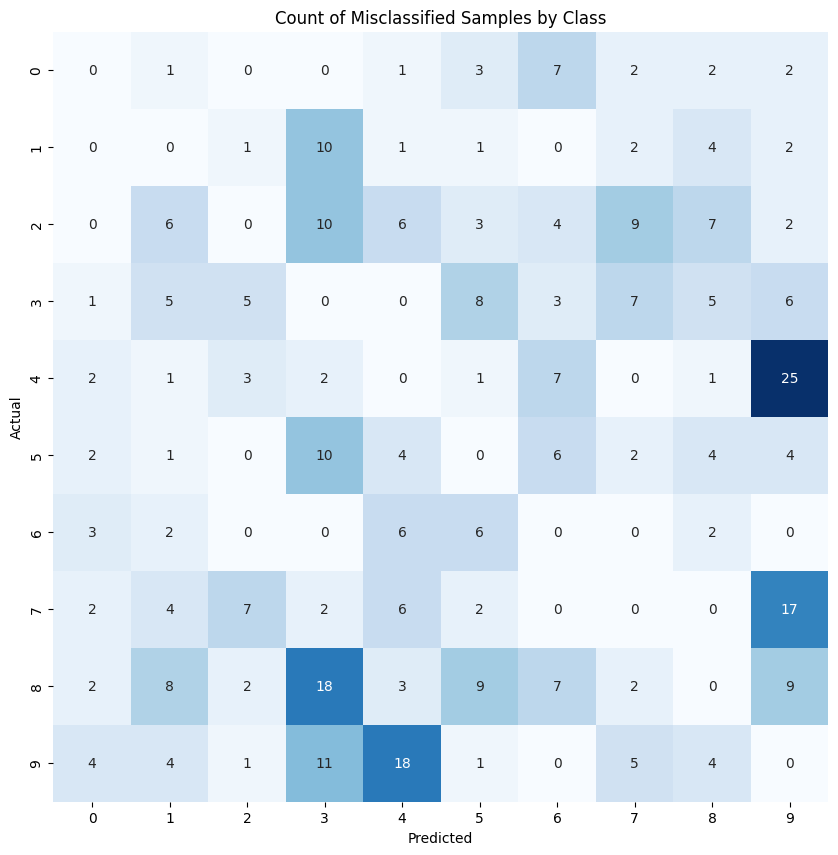

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.cpu(), predicted.cpu())
# remove the diagonal values (correct predictions) for better visualization
np.fill_diagonal(cm, 0)
fig = plt.figure(figsize=(OUTPUT_SIZE, OUTPUT_SIZE))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')

---

# Compare Pytorch CrossEntropyLoss() to Negative Log Likelihood calculated in numpy ipynb

In [8]:
def compute_loss(pred_probs: np.array, y: np.array) -> float:
    row_indices = np.arange(y.shape[0])
    column_indices = y#np.argmax(y, axis=1)
    pred_prob_of_actual = pred_probs[row_indices, column_indices]
    return -np.log(pred_prob_of_actual + 1e-9).mean()

def softmax(x: np.array) -> np.array:
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=1).reshape(-1, 1)

criterion = nn.CrossEntropyLoss()

# test/compare the loss from CrossEntryLoss with computed loss
pred_probs = softmax(outputs.cpu().numpy())
# softmax
y = y_test.cpu().numpy()

cross_entropy_loss = criterion(outputs, y_test).item()
computed_loss = compute_loss(pred_probs, y)
print(f"CrossEntropyLoss: {cross_entropy_loss:.3f}, Computed loss: {computed_loss:.3f}")

CrossEntropyLoss: 0.187, Computed loss: 0.187
